In [1]:
import os
import argparse
import time
import datetime
from tqdm import tqdm

from munch import Munch
from torch.backends import cudnn
import torch
import torch.nn.functional as F
import numpy as np

from core.my_loader import get_train_loader, get_test_loader, InputFetcher
from core.my_solver import Solver
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader

from easydict import EasyDict as edict
from core.my_solver import compute_d_loss, compute_g_loss, moving_average, adv_loss, r1_reg, Sampler, LoaderSampler, tensor2img
from core.my_metrics import get_Z_pushed_loader_stats, calculate_cost
from core.fid_score import calculate_frechet_distance

from IPython.display import clear_output
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = "5"

def str2bool(v):
    return v.lower() in ('true')


def subdirs(dname):
    return [d for d in os.listdir(dname)
            if os.path.isdir(os.path.join(dname, d))]

lambda_id = 200.0

args = edict({
    'img_size': 64,
    'num_domains': 2,
    'latent_dim': 16,
    'hidden_dim': 512,
    'style_dim': 64, 
    'lambda_reg': 1.0,
    'lambda_cyc': 1.0,
    'lambda_sty': 1.0,
    'lambda_ds': 1.0,
    'lambda_id': lambda_id,
    'ds_iter': 100000,
    'w_hpf': -1.0,
    'randcrop_prob': 0.5,
    'total_iters': 100000,
    'resume_iter': 0,
    'batch_size': 16,
    'val_batch_size': 32,
    'lr': 1e-4,
    'f_lr': 1e-6,
    'beta1': 0.0,
    'beta2': 0.99,
    'weight_decay': 1e-4,
    'num_outs_per_domain': 10,
    'mode': 'train', 
    'num_workers': 4,
    'seed': 777,
    'train_img_dir': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train',
    'val_img_dir': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test',
    'sample_dir': 'expr/samples',
    'checkpoint_dir': f'/cache/selikhanovych/OT_competitors/stargan-v2/celeba2anime_exps/checkpoints_lambda_{lambda_id}',
    'eval_dir': 'expr/eval',
    'result_dir': 'expr/results',
    'src_dir': 'assets/representative/celeba_hq/src',
    'ref_dir': 'assets/representative/celeba_hq/ref',
    'inp_dir': 'assets/representative/custom/female',
    'out_dir': 'assets/representative/celeba_hq/src/female',
    'wing_path': 'expr/checkpoints/wing.ckpt',
    'lm_path': 'expr/checkpoints/celeba_lm_mean.npz',
    'print_every': 10,
    'sample_every': 4000,
    'save_every': 4000,
    'eval_every': 4000,
    
    'target_dataset': 'aligned_anime_faces',
    'OUTPUT_PATH': f'/cache/selikhanovych/OT_competitors/stargan-v2/celeba2anime_exps/checkpoints_lambda_{lambda_id}',
    'domains': {
        'source': 'celeba_female',
        'target': 'aligned_anime_faces',
    },
    'train_a': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train/celeba_female',
    'train_b': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train/aligned_anime_faces', 
    'test_a': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test/celeba_female',
    'test_b': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test/aligned_anime_faces',
    
    'n_epochs': 1
})

os.system(f"mkdir -p {args.OUTPUT_PATH}")
os.system(f"mkdir -p {args.checkpoint_dir}")


eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()

final_trg_index = -1
final_src_index = -1

for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            final_trg_index = trg_idx
            final_src_index = src_idx
            
print(final_trg_index, final_src_index)

cudnn.benchmark = True
torch.manual_seed(args.seed)

solver = Solver(args)

assert len(subdirs(args.train_img_dir)) == args.num_domains
assert len(subdirs(args.val_img_dir)) == args.num_domains

loaders = Munch(src=get_train_loader(root=args.train_img_dir,
                                     which='source',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                ref=get_train_loader(root=args.train_img_dir,
                                     which='reference',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                val=get_test_loader(root=args.val_img_dir,
                                    img_size=args.img_size,
                                    batch_size=args.val_batch_size,
                                    shuffle=False,
                                    num_workers=args.num_workers))

device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()
num_domains = len(domains)
for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            print(f"trg_idx = {trg_idx}, trg_domain = {trg_domain}, src_domain = {src_domain}")
            break
    break
                    
print(f"trg_idx = {trg_idx}, lambda_id = {args.lambda_id}")

0 0
Number of parameters of generator: 32634883
Number of parameters of mapping_network: 2438272
Number of parameters of style_encoder: 20327808
Number of parameters of discriminator: 20263170
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...
Preparing DataLoader to fetch source images during the training phase...
Preparing DataLoader to fetch reference images during the training phase...
Preparing DataLoader for the generation phase...
trg_idx = 0, trg_domain = aligned_anime_faces, src_domain = celeba_female
trg_idx = 0, lambda_id = 200.0


Computing l1 cost


591it [00:29, 20.31it/s]


l1 cost = 0.028177673674327906, best l1 cost = 0.027771730505600924, best iter = 84000
Computing l2 cost


591it [00:29, 20.15it/s]


l2 cost = 0.002121236545904543, best l2 cost = 0.0017531550537918416, best iter = 68000
Computing FID
Calculating evaluation metrics...
Number of domains: 2
Compute FID for celeba_female2aligned_anime_faces, trg_idx = 0, trg_domain = aligned_anime_faces
Preparing DataLoader for the generation phase...


100%|██████████| 320/320 [00:39<00:00,  8.16it/s]


FID = 136.62957253865085, best FID = 136.43510378963538, best iter = 88000
FID = 136.62957253865085, best FID = 136.43510378963538, best iter = 88000
Plotting, iter = 96000
mode = train


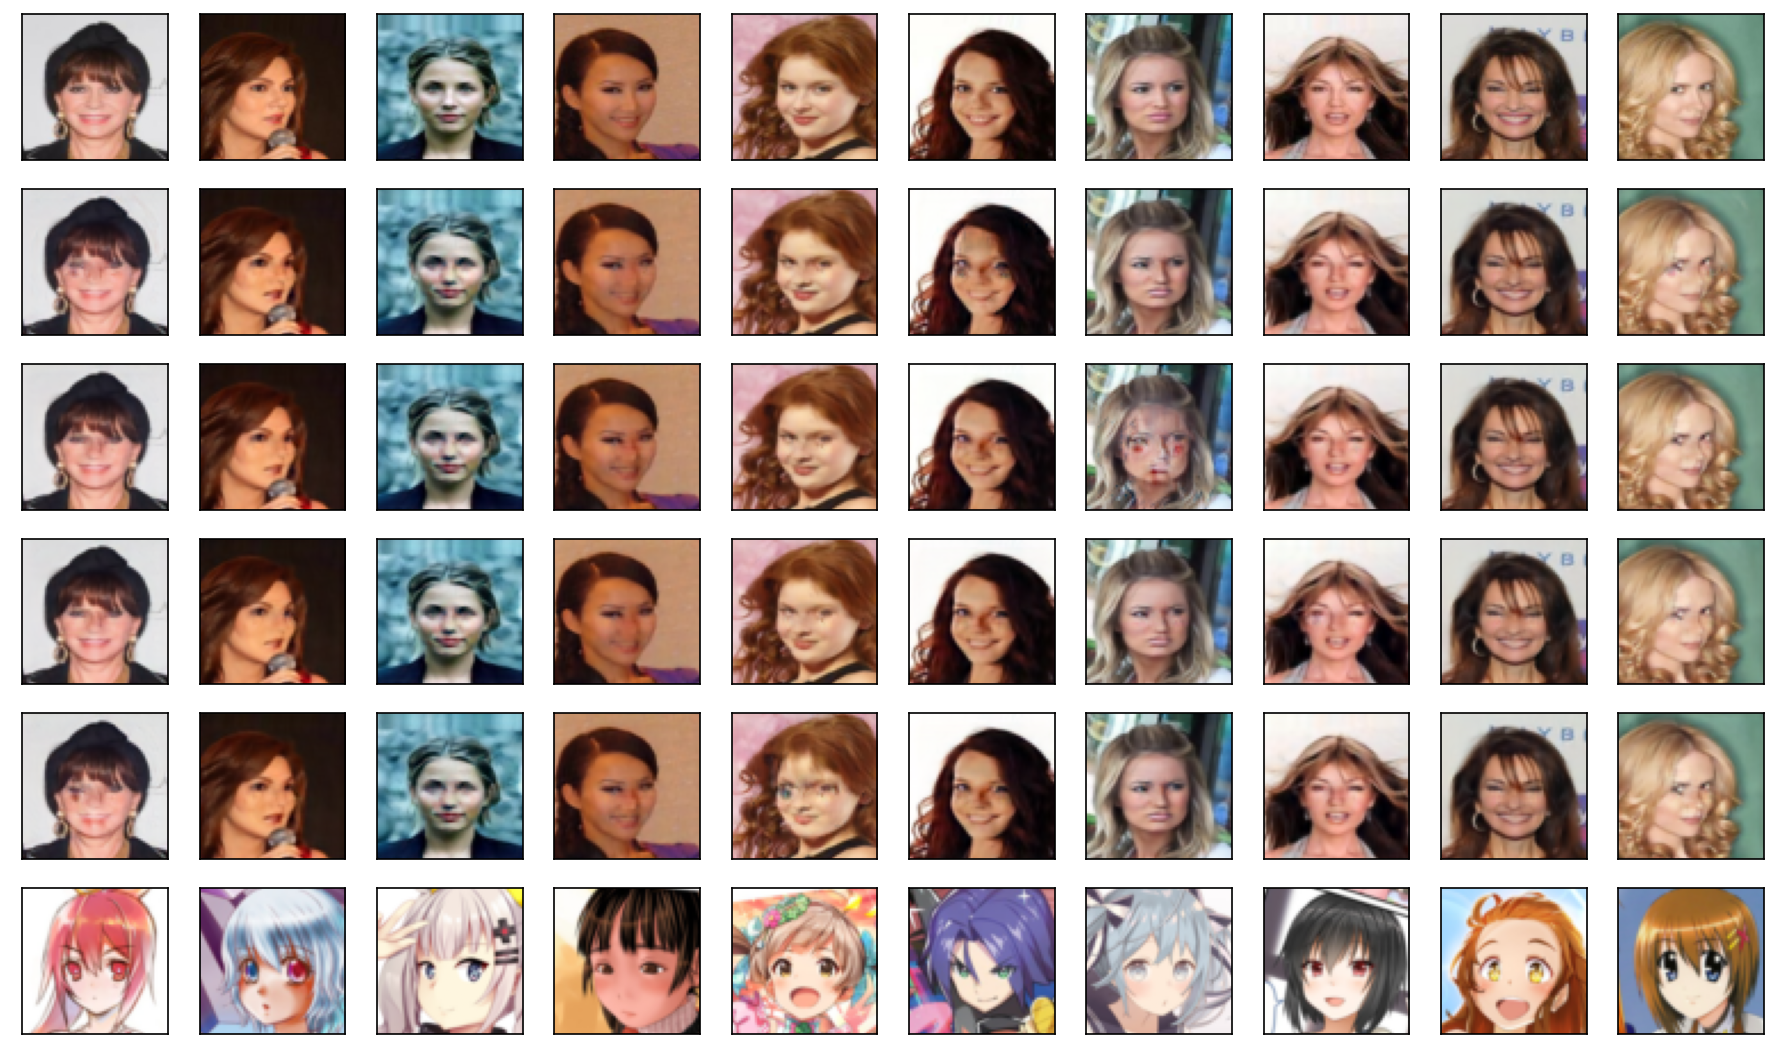

mode = test


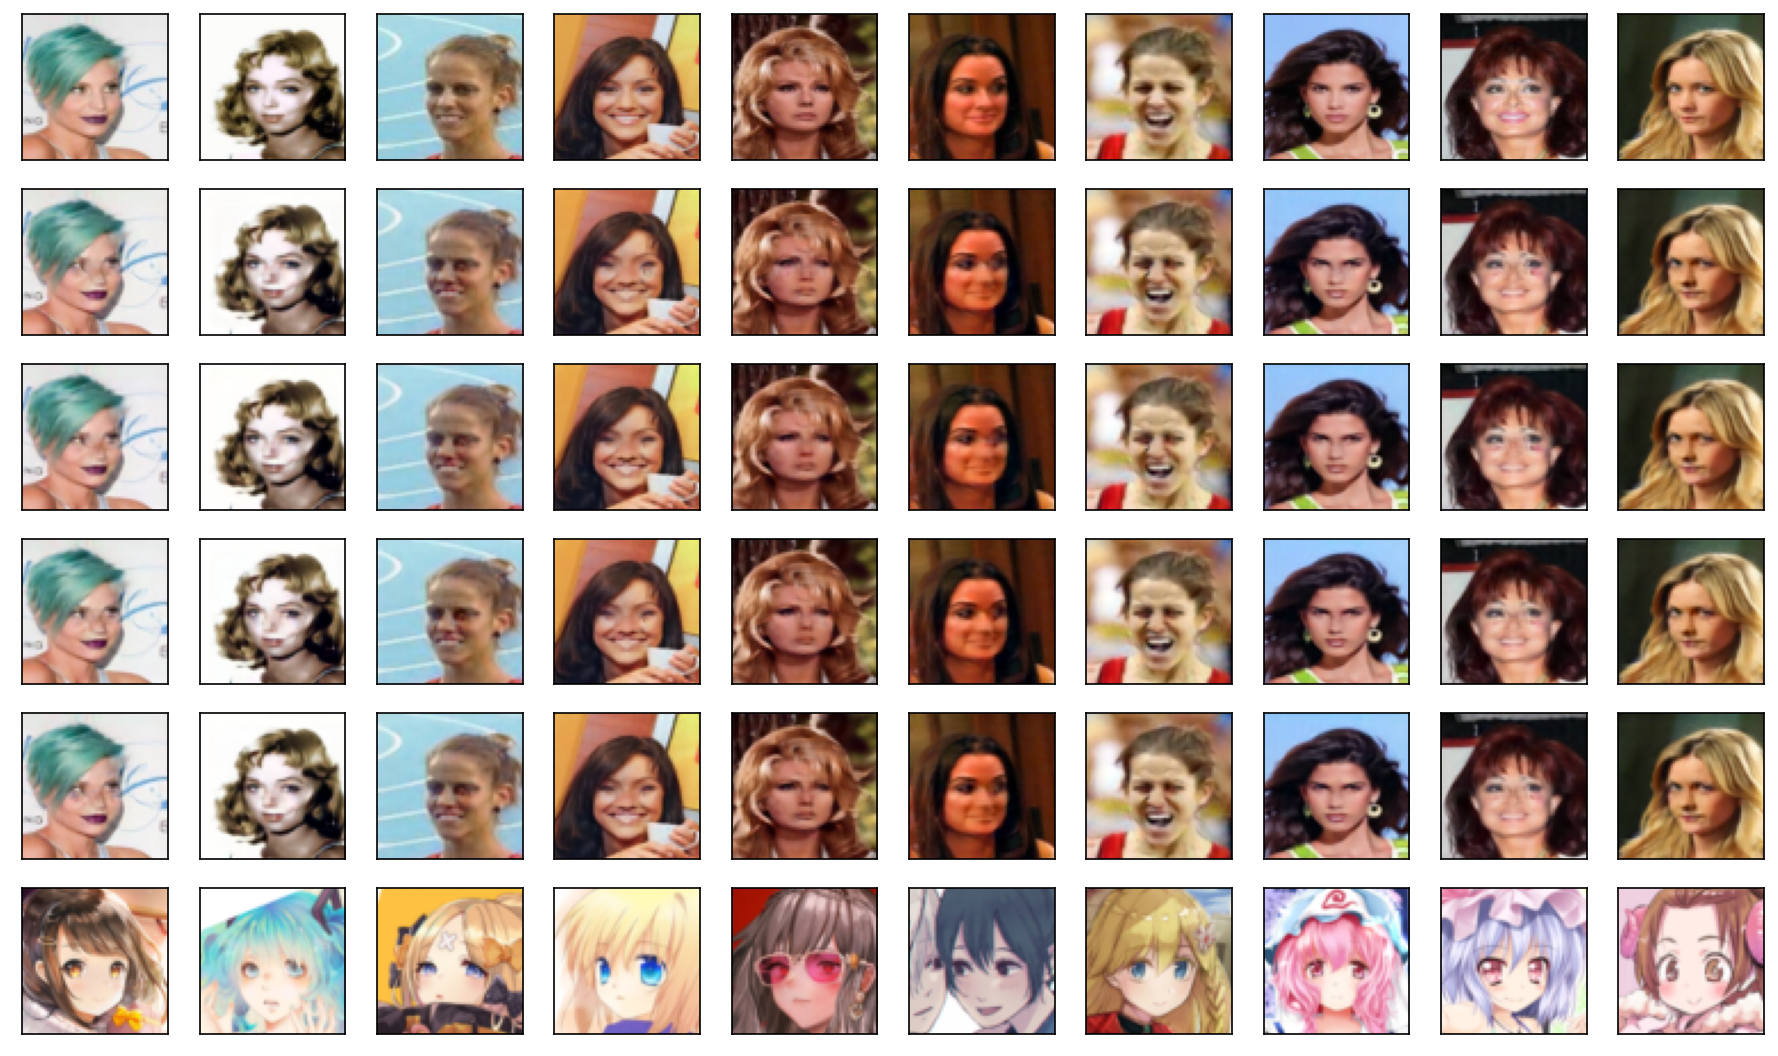

G loss = 9.590779304504395, d loss = 1.0283668041229248, lambda_id = 200.0
G loss = 11.758113861083984, d loss = 0.8885278105735779, lambda_id = 200.0
G loss = 11.722524642944336, d loss = 0.9000105857849121, lambda_id = 200.0
G loss = 10.313706398010254, d loss = 0.954893171787262, lambda_id = 200.0
G loss = 10.59434700012207, d loss = 0.9743003845214844, lambda_id = 200.0
G loss = 12.176434516906738, d loss = 0.761978030204773, lambda_id = 200.0
G loss = 10.15399169921875, d loss = 1.2017600536346436, lambda_id = 200.0
G loss = 10.166415214538574, d loss = 1.0280959606170654, lambda_id = 200.0
G loss = 8.972038269042969, d loss = 1.068742275238037, lambda_id = 200.0
G loss = 11.278898239135742, d loss = 0.8599920272827148, lambda_id = 200.0
Elapsed time [1 day, 5:52:13], Iteration [96011/100000], D/latent_real: [0.4319] D/latent_fake: [0.3222] D/latent_reg: [0.0569] D/ref_real: [0.2762] D/ref_fake: [0.5329] D/ref_reg: [0.0508] G/latent_adv: [3.1749] G/latent_sty: [0.1678] G/latent_ds

G loss = 10.543989181518555, d loss = 1.0415971279144287, lambda_id = 200.0
G loss = 9.945760726928711, d loss = 1.0825289487838745, lambda_id = 200.0
G loss = 9.442861557006836, d loss = 1.0435422658920288, lambda_id = 200.0
G loss = 12.289336204528809, d loss = 0.6700442433357239, lambda_id = 200.0
G loss = 9.704338073730469, d loss = 1.0422439575195312, lambda_id = 200.0
G loss = 10.615008354187012, d loss = 0.9056442975997925, lambda_id = 200.0
Elapsed time [1 day, 5:53:29], Iteration [96081/100000], D/latent_real: [0.3489] D/latent_fake: [0.5379] D/latent_reg: [0.0530] D/ref_real: [0.4207] D/ref_fake: [0.4285] D/ref_reg: [0.0565] G/latent_adv: [2.9164] G/latent_sty: [0.1876] G/latent_ds: [0.0180] G/latent_cyc: [0.0569] G/ref_adv: [2.0107] G/ref_sty: [0.1618] G/ref_ds: [0.0436] G/ref_cyc: [0.0827] G/lambda_ds: [0.0392]
G loss = 10.261948585510254, d loss = 0.8497776389122009, lambda_id = 200.0
G loss = 12.905506134033203, d loss = 0.7742756605148315, lambda_id = 200.0
G loss = 10.9

G loss = 11.642393112182617, d loss = 0.8310157060623169, lambda_id = 200.0
G loss = 10.02071762084961, d loss = 1.0538957118988037, lambda_id = 200.0
Elapsed time [1 day, 5:54:45], Iteration [96151/100000], D/latent_real: [0.3527] D/latent_fake: [0.6465] D/latent_reg: [0.0536] D/ref_real: [0.6114] D/ref_fake: [0.3883] D/ref_reg: [0.0542] G/latent_adv: [2.3577] G/latent_sty: [0.1697] G/latent_ds: [0.0165] G/latent_cyc: [0.0597] G/ref_adv: [1.5183] G/ref_sty: [0.1671] G/ref_ds: [0.0242] G/ref_cyc: [0.1020] G/lambda_ds: [0.0385]
G loss = 10.527898788452148, d loss = 0.9525806903839111, lambda_id = 200.0
G loss = 10.374469757080078, d loss = 0.9601649045944214, lambda_id = 200.0
G loss = 11.364775657653809, d loss = 0.8939878940582275, lambda_id = 200.0
G loss = 11.112920761108398, d loss = 0.9076547026634216, lambda_id = 200.0
G loss = 12.743918418884277, d loss = 0.7049022316932678, lambda_id = 200.0
G loss = 8.822479248046875, d loss = 1.0700116157531738, lambda_id = 200.0
G loss = 9.8

G loss = 11.149351119995117, d loss = 0.7967773675918579, lambda_id = 200.0
G loss = 9.39959716796875, d loss = 1.0676920413970947, lambda_id = 200.0
G loss = 11.710824966430664, d loss = 1.026068091392517, lambda_id = 200.0
G loss = 10.977763175964355, d loss = 0.891118586063385, lambda_id = 200.0
G loss = 10.093389511108398, d loss = 1.0282034873962402, lambda_id = 200.0
G loss = 11.087501525878906, d loss = 1.0593621730804443, lambda_id = 200.0
G loss = 10.402050971984863, d loss = 0.9100556969642639, lambda_id = 200.0
G loss = 11.000223159790039, d loss = 0.9851313233375549, lambda_id = 200.0
G loss = 9.561814308166504, d loss = 1.0771859884262085, lambda_id = 200.0
G loss = 10.648174285888672, d loss = 0.9214677810668945, lambda_id = 200.0
Elapsed time [1 day, 5:56:12], Iteration [96231/100000], D/latent_real: [0.4127] D/latent_fake: [0.4554] D/latent_reg: [0.0695] D/ref_real: [0.5077] D/ref_fake: [0.3319] D/ref_reg: [0.0819] G/latent_adv: [2.6516] G/latent_sty: [0.1934] G/latent_

G loss = 9.632054328918457, d loss = 0.9705628156661987, lambda_id = 200.0
G loss = 11.283138275146484, d loss = 0.7675756812095642, lambda_id = 200.0
G loss = 10.776561737060547, d loss = 0.8099702000617981, lambda_id = 200.0
G loss = 11.036643981933594, d loss = 0.9955419898033142, lambda_id = 200.0
G loss = 10.432021141052246, d loss = 0.8536693453788757, lambda_id = 200.0
G loss = 9.875432968139648, d loss = 0.9392798542976379, lambda_id = 200.0
Elapsed time [1 day, 5:57:28], Iteration [96301/100000], D/latent_real: [0.3654] D/latent_fake: [0.5701] D/latent_reg: [0.0587] D/ref_real: [0.5404] D/ref_fake: [0.3438] D/ref_reg: [0.0551] G/latent_adv: [2.0340] G/latent_sty: [0.1824] G/latent_ds: [0.0179] G/latent_cyc: [0.0622] G/ref_adv: [1.8631] G/ref_sty: [0.1902] G/ref_ds: [0.0118] G/ref_cyc: [0.0725] G/lambda_ds: [0.0370]
G loss = 11.353509902954102, d loss = 0.6720867156982422, lambda_id = 200.0
G loss = 9.77757453918457, d loss = 1.0016155242919922, lambda_id = 200.0
G loss = 11.76

G loss = 10.025188446044922, d loss = 1.0244768857955933, lambda_id = 200.0
G loss = 8.224518775939941, d loss = 1.1154478788375854, lambda_id = 200.0
Elapsed time [1 day, 5:58:45], Iteration [96371/100000], D/latent_real: [0.3620] D/latent_fake: [0.8094] D/latent_reg: [0.0564] D/ref_real: [0.5683] D/ref_fake: [0.4924] D/ref_reg: [0.0547] G/latent_adv: [1.5789] G/latent_sty: [0.1694] G/latent_ds: [0.0149] G/latent_cyc: [0.0492] G/ref_adv: [1.5057] G/ref_sty: [0.2080] G/ref_ds: [0.0211] G/ref_cyc: [0.0556] G/lambda_ds: [0.0363]
G loss = 9.754332542419434, d loss = 0.7977858781814575, lambda_id = 200.0
G loss = 9.873329162597656, d loss = 0.8619496822357178, lambda_id = 200.0
G loss = 11.136619567871094, d loss = 0.9933515191078186, lambda_id = 200.0
G loss = 12.01201343536377, d loss = 1.0713393688201904, lambda_id = 200.0
G loss = 11.749746322631836, d loss = 1.051633358001709, lambda_id = 200.0
G loss = 11.759919166564941, d loss = 0.9299963116645813, lambda_id = 200.0
G loss = 10.550

G loss = 9.305870056152344, d loss = 0.9719222784042358, lambda_id = 200.0
G loss = 12.02545166015625, d loss = 0.7541587352752686, lambda_id = 200.0
G loss = 9.867707252502441, d loss = 0.8818478584289551, lambda_id = 200.0
G loss = 11.588825225830078, d loss = 0.8695448637008667, lambda_id = 200.0
G loss = 11.809478759765625, d loss = 0.8085989952087402, lambda_id = 200.0
G loss = 11.394742012023926, d loss = 0.9117765426635742, lambda_id = 200.0
G loss = 10.110700607299805, d loss = 0.9855836629867554, lambda_id = 200.0
G loss = 10.097894668579102, d loss = 0.9042428731918335, lambda_id = 200.0
G loss = 11.192749977111816, d loss = 0.7971435189247131, lambda_id = 200.0
G loss = 11.141338348388672, d loss = 0.9575455784797668, lambda_id = 200.0
Elapsed time [1 day, 6:00:12], Iteration [96451/100000], D/latent_real: [0.3522] D/latent_fake: [0.5592] D/latent_reg: [0.0779] D/ref_real: [0.4334] D/ref_fake: [0.4635] D/ref_reg: [0.0606] G/latent_adv: [2.6692] G/latent_sty: [0.1816] G/laten

G loss = 13.071151733398438, d loss = 0.7708035707473755, lambda_id = 200.0
G loss = 10.910364151000977, d loss = 0.9156433343887329, lambda_id = 200.0
G loss = 9.959991455078125, d loss = 1.136989712715149, lambda_id = 200.0
G loss = 12.800830841064453, d loss = 0.9857411980628967, lambda_id = 200.0
G loss = 14.573887825012207, d loss = 0.8777841329574585, lambda_id = 200.0
G loss = 10.104048728942871, d loss = 1.1143717765808105, lambda_id = 200.0
Elapsed time [1 day, 6:01:28], Iteration [96521/100000], D/latent_real: [0.7740] D/latent_fake: [0.3855] D/latent_reg: [0.0631] D/ref_real: [0.2673] D/ref_fake: [0.8072] D/ref_reg: [0.0398] G/latent_adv: [2.3165] G/latent_sty: [0.1819] G/latent_ds: [0.0220] G/latent_cyc: [0.0561] G/ref_adv: [1.9684] G/ref_sty: [0.2144] G/ref_ds: [0.0292] G/ref_cyc: [0.0754] G/lambda_ds: [0.0348]
G loss = 10.369043350219727, d loss = 0.8816972374916077, lambda_id = 200.0
G loss = 9.989686012268066, d loss = 0.9644970893859863, lambda_id = 200.0
G loss = 10.1

G loss = 8.586688995361328, d loss = 1.13685941696167, lambda_id = 200.0
G loss = 9.29721450805664, d loss = 0.9173049330711365, lambda_id = 200.0
Elapsed time [1 day, 6:02:44], Iteration [96591/100000], D/latent_real: [0.3762] D/latent_fake: [0.5405] D/latent_reg: [0.0482] D/ref_real: [0.4359] D/ref_fake: [0.4307] D/ref_reg: [0.0507] G/latent_adv: [2.4922] G/latent_sty: [0.1577] G/latent_ds: [0.0151] G/latent_cyc: [0.0528] G/ref_adv: [2.1124] G/ref_sty: [0.1825] G/ref_ds: [0.0204] G/ref_cyc: [0.0739] G/lambda_ds: [0.0341]
G loss = 10.36517333984375, d loss = 0.9110001921653748, lambda_id = 200.0
G loss = 9.386408805847168, d loss = 1.0296978950500488, lambda_id = 200.0
G loss = 9.232794761657715, d loss = 0.952351987361908, lambda_id = 200.0
G loss = 10.55545425415039, d loss = 0.8718398213386536, lambda_id = 200.0
G loss = 10.602214813232422, d loss = 1.0674971342086792, lambda_id = 200.0
G loss = 9.350662231445312, d loss = 0.9609566926956177, lambda_id = 200.0
G loss = 9.9114723205

G loss = 9.938838958740234, d loss = 0.9896523356437683, lambda_id = 200.0
G loss = 10.96706485748291, d loss = 0.8243900537490845, lambda_id = 200.0
G loss = 11.257776260375977, d loss = 0.671697735786438, lambda_id = 200.0
G loss = 9.752236366271973, d loss = 1.0601625442504883, lambda_id = 200.0
G loss = 10.161800384521484, d loss = 0.9314846992492676, lambda_id = 200.0
G loss = 11.030990600585938, d loss = 0.8858444690704346, lambda_id = 200.0
G loss = 11.041919708251953, d loss = 0.8927482962608337, lambda_id = 200.0
G loss = 11.103215217590332, d loss = 0.9315356612205505, lambda_id = 200.0
G loss = 9.600066184997559, d loss = 0.9308851361274719, lambda_id = 200.0
G loss = 10.48118782043457, d loss = 0.8421012163162231, lambda_id = 200.0
Elapsed time [1 day, 6:04:11], Iteration [96671/100000], D/latent_real: [0.4446] D/latent_fake: [0.4704] D/latent_reg: [0.0481] D/ref_real: [0.3304] D/ref_fake: [0.4623] D/ref_reg: [0.0494] G/latent_adv: [3.3467] G/latent_sty: [0.1532] G/latent_d

G loss = 10.856820106506348, d loss = 0.8354954719543457, lambda_id = 200.0
G loss = 13.090502738952637, d loss = 0.8798267245292664, lambda_id = 200.0
G loss = 9.942488670349121, d loss = 0.9697655439376831, lambda_id = 200.0
G loss = 10.259542465209961, d loss = 0.8664495944976807, lambda_id = 200.0
G loss = 10.682286262512207, d loss = 0.9348626732826233, lambda_id = 200.0
G loss = 11.4232816696167, d loss = 0.8474094271659851, lambda_id = 200.0
Elapsed time [1 day, 6:05:27], Iteration [96741/100000], D/latent_real: [0.4003] D/latent_fake: [0.4472] D/latent_reg: [0.0536] D/ref_real: [0.3776] D/ref_fake: [0.4203] D/ref_reg: [0.0495] G/latent_adv: [3.2184] G/latent_sty: [0.1660] G/latent_ds: [0.0247] G/latent_cyc: [0.0671] G/ref_adv: [2.2400] G/ref_sty: [0.1383] G/ref_ds: [0.0294] G/ref_cyc: [0.1070] G/lambda_ds: [0.0326]
G loss = 11.610395431518555, d loss = 0.8762809038162231, lambda_id = 200.0
G loss = 10.386198043823242, d loss = 0.9158305525779724, lambda_id = 200.0
G loss = 9.28

G loss = 9.266488075256348, d loss = 1.1779435873031616, lambda_id = 200.0
G loss = 10.03925895690918, d loss = 1.067305326461792, lambda_id = 200.0
Elapsed time [1 day, 6:06:43], Iteration [96811/100000], D/latent_real: [0.4301] D/latent_fake: [0.5652] D/latent_reg: [0.0598] D/ref_real: [0.4244] D/ref_fake: [0.5940] D/ref_reg: [0.0489] G/latent_adv: [2.5042] G/latent_sty: [0.1927] G/latent_ds: [0.0176] G/latent_cyc: [0.0567] G/ref_adv: [1.9631] G/ref_sty: [0.1827] G/ref_ds: [0.0406] G/ref_cyc: [0.0886] G/lambda_ds: [0.0319]
G loss = 10.539948463439941, d loss = 1.0011550188064575, lambda_id = 200.0
G loss = 10.648889541625977, d loss = 0.9766677618026733, lambda_id = 200.0
G loss = 9.2996826171875, d loss = 0.9026073217391968, lambda_id = 200.0
G loss = 12.074773788452148, d loss = 0.6981661915779114, lambda_id = 200.0
G loss = 12.138147354125977, d loss = 0.7914937138557434, lambda_id = 200.0
G loss = 9.594233512878418, d loss = 1.16067373752594, lambda_id = 200.0
G loss = 13.6638975

G loss = 11.416769027709961, d loss = 0.9168258309364319, lambda_id = 200.0
G loss = 11.908352851867676, d loss = 0.851521372795105, lambda_id = 200.0
G loss = 10.711572647094727, d loss = 0.6201523542404175, lambda_id = 200.0
G loss = 11.744710922241211, d loss = 0.923818826675415, lambda_id = 200.0
G loss = 10.726967811584473, d loss = 0.9403604865074158, lambda_id = 200.0
G loss = 9.07198429107666, d loss = 1.103694200515747, lambda_id = 200.0
G loss = 10.81534481048584, d loss = 0.8428863883018494, lambda_id = 200.0
G loss = 9.730415344238281, d loss = 0.8862487077713013, lambda_id = 200.0
G loss = 9.312932968139648, d loss = 0.9910232424736023, lambda_id = 200.0
G loss = 8.629993438720703, d loss = 1.1053727865219116, lambda_id = 200.0
Elapsed time [1 day, 6:08:10], Iteration [96891/100000], D/latent_real: [0.4121] D/latent_fake: [0.7821] D/latent_reg: [0.0552] D/ref_real: [0.5434] D/ref_fake: [0.5120] D/ref_reg: [0.0500] G/latent_adv: [1.7845] G/latent_sty: [0.1963] G/latent_ds: 

G loss = 9.531417846679688, d loss = 0.9815731048583984, lambda_id = 200.0
G loss = 10.920201301574707, d loss = 1.2270689010620117, lambda_id = 200.0
G loss = 10.396954536437988, d loss = 0.9551272392272949, lambda_id = 200.0
G loss = 11.316739082336426, d loss = 0.8837542533874512, lambda_id = 200.0
G loss = 10.246527671813965, d loss = 0.8942803740501404, lambda_id = 200.0
G loss = 10.466042518615723, d loss = 0.934726893901825, lambda_id = 200.0
Elapsed time [1 day, 6:09:27], Iteration [96961/100000], D/latent_real: [0.3257] D/latent_fake: [0.6080] D/latent_reg: [0.0544] D/ref_real: [0.5023] D/ref_fake: [0.3765] D/ref_reg: [0.0559] G/latent_adv: [2.7253] G/latent_sty: [0.1841] G/latent_ds: [0.0160] G/latent_cyc: [0.0635] G/ref_adv: [1.7516] G/ref_sty: [0.1758] G/ref_ds: [0.0379] G/ref_cyc: [0.0955] G/lambda_ds: [0.0304]
G loss = 11.399231910705566, d loss = 0.8906843066215515, lambda_id = 200.0
G loss = 10.908823013305664, d loss = 1.040339469909668, lambda_id = 200.0
G loss = 10.3

G loss = 11.195212364196777, d loss = 0.9908877611160278, lambda_id = 200.0
G loss = 9.001996040344238, d loss = 1.0504003763198853, lambda_id = 200.0
Elapsed time [1 day, 6:10:43], Iteration [97031/100000], D/latent_real: [0.3856] D/latent_fake: [0.6257] D/latent_reg: [0.0536] D/ref_real: [0.5097] D/ref_fake: [0.4895] D/ref_reg: [0.0511] G/latent_adv: [2.3549] G/latent_sty: [0.2270] G/latent_ds: [0.0158] G/latent_cyc: [0.0503] G/ref_adv: [1.3854] G/ref_sty: [0.3297] G/ref_ds: [0.0248] G/ref_cyc: [0.0903] G/lambda_ds: [0.0297]
G loss = 9.80866527557373, d loss = 1.044994592666626, lambda_id = 200.0
G loss = 13.76059341430664, d loss = 0.6867390871047974, lambda_id = 200.0
G loss = 11.086919784545898, d loss = 0.9592553973197937, lambda_id = 200.0
G loss = 10.616935729980469, d loss = 1.084811806678772, lambda_id = 200.0
G loss = 12.702499389648438, d loss = 0.8195788264274597, lambda_id = 200.0
G loss = 10.066658020019531, d loss = 1.0683257579803467, lambda_id = 200.0
G loss = 10.6122

G loss = 9.348764419555664, d loss = 1.1022331714630127, lambda_id = 200.0
G loss = 9.578655242919922, d loss = 0.8734242916107178, lambda_id = 200.0
G loss = 9.488727569580078, d loss = 1.128016710281372, lambda_id = 200.0
G loss = 9.238330841064453, d loss = 1.1333167552947998, lambda_id = 200.0
G loss = 9.888016700744629, d loss = 0.9586360454559326, lambda_id = 200.0
G loss = 11.608338356018066, d loss = 0.7553226947784424, lambda_id = 200.0
G loss = 10.17866325378418, d loss = 0.9491764903068542, lambda_id = 200.0
G loss = 12.165773391723633, d loss = 0.7874791026115417, lambda_id = 200.0
G loss = 11.241236686706543, d loss = 1.057494878768921, lambda_id = 200.0
G loss = 9.044262886047363, d loss = 1.11410391330719, lambda_id = 200.0
Elapsed time [1 day, 6:12:10], Iteration [97111/100000], D/latent_real: [0.5013] D/latent_fake: [0.6326] D/latent_reg: [0.0636] D/ref_real: [0.4961] D/ref_fake: [0.5620] D/ref_reg: [0.0560] G/latent_adv: [1.9246] G/latent_sty: [0.1588] G/latent_ds: [0

G loss = 10.02292251586914, d loss = 0.9825133085250854, lambda_id = 200.0
G loss = 12.059917449951172, d loss = 0.896500289440155, lambda_id = 200.0
G loss = 12.057594299316406, d loss = 0.7640066742897034, lambda_id = 200.0
G loss = 12.998098373413086, d loss = 0.7391582131385803, lambda_id = 200.0
G loss = 10.848308563232422, d loss = 0.9140472412109375, lambda_id = 200.0
G loss = 11.603466033935547, d loss = 0.7836568355560303, lambda_id = 200.0
Elapsed time [1 day, 6:13:26], Iteration [97181/100000], D/latent_real: [0.4181] D/latent_fake: [0.3053] D/latent_reg: [0.0762] D/ref_real: [0.2487] D/ref_fake: [0.4762] D/ref_reg: [0.0588] G/latent_adv: [3.9741] G/latent_sty: [0.1781] G/latent_ds: [0.0162] G/latent_cyc: [0.0553] G/ref_adv: [2.3931] G/ref_sty: [0.2072] G/ref_ds: [0.0481] G/ref_cyc: [0.1117] G/lambda_ds: [0.0282]
G loss = 10.04826831817627, d loss = 1.0387486219406128, lambda_id = 200.0
G loss = 9.725213050842285, d loss = 1.0587142705917358, lambda_id = 200.0
G loss = 10.31

G loss = 11.388794898986816, d loss = 0.9285621643066406, lambda_id = 200.0
G loss = 11.96914291381836, d loss = 0.7379574775695801, lambda_id = 200.0
Elapsed time [1 day, 6:14:42], Iteration [97251/100000], D/latent_real: [0.4551] D/latent_fake: [0.2774] D/latent_reg: [0.0511] D/ref_real: [0.2632] D/ref_fake: [0.4286] D/ref_reg: [0.0461] G/latent_adv: [3.4607] G/latent_sty: [0.2024] G/latent_ds: [0.0189] G/latent_cyc: [0.0618] G/ref_adv: [2.5207] G/ref_sty: [0.2569] G/ref_ds: [0.0645] G/ref_cyc: [0.1065] G/lambda_ds: [0.0275]
G loss = 11.827408790588379, d loss = 0.80227130651474, lambda_id = 200.0
G loss = 11.126365661621094, d loss = 0.7961861491203308, lambda_id = 200.0
G loss = 11.373523712158203, d loss = 0.9311487674713135, lambda_id = 200.0
G loss = 12.49810791015625, d loss = 0.8428635597229004, lambda_id = 200.0
G loss = 10.737431526184082, d loss = 0.9358980655670166, lambda_id = 200.0
G loss = 11.737939834594727, d loss = 0.816348671913147, lambda_id = 200.0
G loss = 8.5225

G loss = 9.97625732421875, d loss = 1.1010879278182983, lambda_id = 200.0
G loss = 9.895472526550293, d loss = 0.9853071570396423, lambda_id = 200.0
G loss = 9.599034309387207, d loss = 1.0355144739151, lambda_id = 200.0
G loss = 9.33721923828125, d loss = 0.9412174820899963, lambda_id = 200.0
G loss = 10.212162971496582, d loss = 0.9938545227050781, lambda_id = 200.0
G loss = 9.687514305114746, d loss = 0.9786410927772522, lambda_id = 200.0
G loss = 11.721373558044434, d loss = 0.9013102650642395, lambda_id = 200.0
G loss = 9.680464744567871, d loss = 1.0822211503982544, lambda_id = 200.0
G loss = 10.533309936523438, d loss = 0.9420157074928284, lambda_id = 200.0
G loss = 10.064638137817383, d loss = 0.9298579692840576, lambda_id = 200.0
Elapsed time [1 day, 6:16:09], Iteration [97331/100000], D/latent_real: [0.5081] D/latent_fake: [0.4538] D/latent_reg: [0.0655] D/ref_real: [0.3996] D/ref_fake: [0.4755] D/ref_reg: [0.0547] G/latent_adv: [2.5907] G/latent_sty: [0.1915] G/latent_ds: [0

G loss = 10.172747611999512, d loss = 1.0902252197265625, lambda_id = 200.0
G loss = 11.283851623535156, d loss = 1.001402497291565, lambda_id = 200.0
G loss = 11.304502487182617, d loss = 0.9847179651260376, lambda_id = 200.0
G loss = 10.978206634521484, d loss = 0.9109779596328735, lambda_id = 200.0
G loss = 10.736248970031738, d loss = 0.9530184268951416, lambda_id = 200.0
G loss = 11.070030212402344, d loss = 0.845607340335846, lambda_id = 200.0
Elapsed time [1 day, 6:17:25], Iteration [97401/100000], D/latent_real: [0.4539] D/latent_fake: [0.3485] D/latent_reg: [0.0649] D/ref_real: [0.2746] D/ref_fake: [0.5163] D/ref_reg: [0.0548] G/latent_adv: [3.5406] G/latent_sty: [0.1684] G/latent_ds: [0.0206] G/latent_cyc: [0.0565] G/ref_adv: [2.2728] G/ref_sty: [0.2003] G/ref_ds: [0.0400] G/ref_cyc: [0.1053] G/lambda_ds: [0.0260]
G loss = 10.721938133239746, d loss = 0.7743226289749146, lambda_id = 200.0
G loss = 8.078630447387695, d loss = 1.254167079925537, lambda_id = 200.0
G loss = 10.31

G loss = 10.524909019470215, d loss = 0.9866976737976074, lambda_id = 200.0
G loss = 10.410012245178223, d loss = 1.0765048265457153, lambda_id = 200.0
Elapsed time [1 day, 6:18:41], Iteration [97471/100000], D/latent_real: [0.3872] D/latent_fake: [0.6413] D/latent_reg: [0.0510] D/ref_real: [0.5189] D/ref_fake: [0.5066] D/ref_reg: [0.0510] G/latent_adv: [2.3023] G/latent_sty: [0.1837] G/latent_ds: [0.0180] G/latent_cyc: [0.0611] G/ref_adv: [1.5765] G/ref_sty: [0.1441] G/ref_ds: [0.0435] G/ref_cyc: [0.0984] G/lambda_ds: [0.0253]
G loss = 11.653820037841797, d loss = 0.9016319513320923, lambda_id = 200.0
G loss = 11.17970085144043, d loss = 0.9648631811141968, lambda_id = 200.0
G loss = 9.5562162399292, d loss = 1.084392786026001, lambda_id = 200.0
G loss = 10.657655715942383, d loss = 0.9371483325958252, lambda_id = 200.0
G loss = 9.564046859741211, d loss = 0.9427384734153748, lambda_id = 200.0
G loss = 15.17463493347168, d loss = 0.5950286388397217, lambda_id = 200.0
G loss = 10.83746

G loss = 10.759744644165039, d loss = 0.6889511346817017, lambda_id = 200.0
G loss = 9.596332550048828, d loss = 1.0835728645324707, lambda_id = 200.0
G loss = 11.340179443359375, d loss = 0.8118659853935242, lambda_id = 200.0
G loss = 8.505547523498535, d loss = 1.2815629243850708, lambda_id = 200.0
G loss = 10.51060962677002, d loss = 0.9994885325431824, lambda_id = 200.0
G loss = 13.64692497253418, d loss = 0.8683388829231262, lambda_id = 200.0
G loss = 10.171537399291992, d loss = 0.920099139213562, lambda_id = 200.0
G loss = 8.455473899841309, d loss = 1.1550862789154053, lambda_id = 200.0
G loss = 11.41328239440918, d loss = 0.8097395896911621, lambda_id = 200.0
G loss = 10.9525146484375, d loss = 0.683414876461029, lambda_id = 200.0
Elapsed time [1 day, 6:20:08], Iteration [97551/100000], D/latent_real: [0.3651] D/latent_fake: [0.3547] D/latent_reg: [0.0480] D/ref_real: [0.2706] D/ref_fake: [0.3688] D/ref_reg: [0.0440] G/latent_adv: [3.3568] G/latent_sty: [0.1675] G/latent_ds: [

G loss = 11.00879192352295, d loss = 0.8910483717918396, lambda_id = 200.0
G loss = 11.822046279907227, d loss = 0.8564150333404541, lambda_id = 200.0
G loss = 8.869672775268555, d loss = 1.169564962387085, lambda_id = 200.0
G loss = 9.777678489685059, d loss = 1.0671494007110596, lambda_id = 200.0
G loss = 10.77249526977539, d loss = 0.9580643177032471, lambda_id = 200.0
G loss = 9.651985168457031, d loss = 1.1072584390640259, lambda_id = 200.0
Elapsed time [1 day, 6:21:24], Iteration [97621/100000], D/latent_real: [0.4908] D/latent_fake: [0.5415] D/latent_reg: [0.0513] D/ref_real: [0.4806] D/ref_fake: [0.5723] D/ref_reg: [0.0544] G/latent_adv: [2.0581] G/latent_sty: [0.1731] G/latent_ds: [0.0234] G/latent_cyc: [0.0603] G/ref_adv: [1.6649] G/ref_sty: [0.1466] G/ref_ds: [0.0477] G/ref_cyc: [0.0876] G/lambda_ds: [0.0238]
G loss = 10.421785354614258, d loss = 0.9052810668945312, lambda_id = 200.0
G loss = 11.36960506439209, d loss = 0.7875895500183105, lambda_id = 200.0
G loss = 11.09759

G loss = 9.534553527832031, d loss = 0.985108494758606, lambda_id = 200.0
G loss = 11.567569732666016, d loss = 0.7929814457893372, lambda_id = 200.0
Elapsed time [1 day, 6:22:41], Iteration [97691/100000], D/latent_real: [0.4601] D/latent_fake: [0.3235] D/latent_reg: [0.0633] D/ref_real: [0.2523] D/ref_fake: [0.4900] D/ref_reg: [0.0507] G/latent_adv: [3.8339] G/latent_sty: [0.1670] G/latent_ds: [0.0178] G/latent_cyc: [0.0560] G/ref_adv: [3.0684] G/ref_sty: [0.1736] G/ref_ds: [0.0437] G/ref_cyc: [0.0760] G/lambda_ds: [0.0231]
G loss = 12.219698905944824, d loss = 0.8293099999427795, lambda_id = 200.0
G loss = 10.385835647583008, d loss = 0.9128280878067017, lambda_id = 200.0
G loss = 10.385396003723145, d loss = 0.9039829969406128, lambda_id = 200.0
G loss = 11.876459121704102, d loss = 0.7168732285499573, lambda_id = 200.0
G loss = 11.10056209564209, d loss = 0.9446057081222534, lambda_id = 200.0
G loss = 10.38605785369873, d loss = 1.0006638765335083, lambda_id = 200.0
G loss = 10.96

G loss = 12.210959434509277, d loss = 0.6589062213897705, lambda_id = 200.0
G loss = 10.272047996520996, d loss = 1.0825930833816528, lambda_id = 200.0
G loss = 8.867877960205078, d loss = 1.1396759748458862, lambda_id = 200.0
G loss = 10.01376724243164, d loss = 1.0121378898620605, lambda_id = 200.0
G loss = 9.135125160217285, d loss = 1.0160136222839355, lambda_id = 200.0
G loss = 10.221620559692383, d loss = 0.9194528460502625, lambda_id = 200.0
G loss = 10.89906120300293, d loss = 0.8991591930389404, lambda_id = 200.0
G loss = 11.448427200317383, d loss = 0.7742933034896851, lambda_id = 200.0
G loss = 9.32876205444336, d loss = 1.1281235218048096, lambda_id = 200.0
G loss = 11.532174110412598, d loss = 0.8530710935592651, lambda_id = 200.0
Elapsed time [1 day, 6:24:08], Iteration [97771/100000], D/latent_real: [0.5208] D/latent_fake: [0.2477] D/latent_reg: [0.0567] D/ref_real: [0.2486] D/ref_fake: [0.5550] D/ref_reg: [0.0494] G/latent_adv: [3.3239] G/latent_sty: [0.1680] G/latent_d

G loss = 12.815034866333008, d loss = 0.8435397148132324, lambda_id = 200.0
G loss = 9.060371398925781, d loss = 1.0115166902542114, lambda_id = 200.0
G loss = 11.777251243591309, d loss = 0.882623553276062, lambda_id = 200.0
G loss = 11.978157043457031, d loss = 0.8895668983459473, lambda_id = 200.0
G loss = 12.91098690032959, d loss = 0.8210107684135437, lambda_id = 200.0
G loss = 10.872283935546875, d loss = 1.213072419166565, lambda_id = 200.0
Elapsed time [1 day, 6:25:24], Iteration [97841/100000], D/latent_real: [0.4033] D/latent_fake: [0.5286] D/latent_reg: [0.0689] D/ref_real: [0.7820] D/ref_fake: [0.3469] D/ref_reg: [0.0842] G/latent_adv: [2.4455] G/latent_sty: [0.1735] G/latent_ds: [0.0239] G/latent_cyc: [0.0605] G/ref_adv: [1.0573] G/ref_sty: [0.1661] G/ref_ds: [0.0651] G/ref_cyc: [0.1140] G/lambda_ds: [0.0216]
G loss = 10.631311416625977, d loss = 0.9869400262832642, lambda_id = 200.0
G loss = 10.368937492370605, d loss = 0.9583503603935242, lambda_id = 200.0
G loss = 10.43

G loss = 11.946563720703125, d loss = 0.7608726024627686, lambda_id = 200.0
G loss = 10.56275749206543, d loss = 0.7686223983764648, lambda_id = 200.0
Elapsed time [1 day, 6:26:40], Iteration [97911/100000], D/latent_real: [0.3259] D/latent_fake: [0.4688] D/latent_reg: [0.0686] D/ref_real: [0.2414] D/ref_fake: [0.4767] D/ref_reg: [0.0505] G/latent_adv: [3.5727] G/latent_sty: [0.1637] G/latent_ds: [0.0174] G/latent_cyc: [0.0527] G/ref_adv: [1.8248] G/ref_sty: [0.1604] G/ref_ds: [0.0543] G/ref_cyc: [0.1100] G/lambda_ds: [0.0209]
G loss = 10.980642318725586, d loss = 0.8745553493499756, lambda_id = 200.0
G loss = 10.291048049926758, d loss = 0.8250803351402283, lambda_id = 200.0
G loss = 12.579097747802734, d loss = 0.8603053092956543, lambda_id = 200.0
G loss = 10.343273162841797, d loss = 1.0226625204086304, lambda_id = 200.0
G loss = 11.425372123718262, d loss = 0.9526419043540955, lambda_id = 200.0
G loss = 9.991937637329102, d loss = 1.0486429929733276, lambda_id = 200.0
G loss = 10.

G loss = 10.046065330505371, d loss = 1.161633014678955, lambda_id = 200.0
G loss = 11.070220947265625, d loss = 1.0858756303787231, lambda_id = 200.0
G loss = 9.81113338470459, d loss = 0.9990004301071167, lambda_id = 200.0
G loss = 10.076086044311523, d loss = 0.8492723107337952, lambda_id = 200.0
G loss = 9.509716033935547, d loss = 0.9889934062957764, lambda_id = 200.0
G loss = 10.856098175048828, d loss = 0.8309098482131958, lambda_id = 200.0
G loss = 10.425236701965332, d loss = 0.9978439211845398, lambda_id = 200.0
G loss = 10.61448860168457, d loss = 0.869127094745636, lambda_id = 200.0
G loss = 10.003057479858398, d loss = 0.8100496530532837, lambda_id = 200.0
G loss = 11.338163375854492, d loss = 0.6865202188491821, lambda_id = 200.0
Elapsed time [1 day, 6:28:07], Iteration [97991/100000], D/latent_real: [0.3746] D/latent_fake: [0.3931] D/latent_reg: [0.0606] D/ref_real: [0.2996] D/ref_fake: [0.3343] D/ref_reg: [0.0526] G/latent_adv: [3.3950] G/latent_sty: [0.1877] G/latent_d

G loss = 13.649497985839844, d loss = 0.8717834949493408, lambda_id = 200.0
G loss = 9.333637237548828, d loss = 0.8922438025474548, lambda_id = 200.0
G loss = 11.97076416015625, d loss = 0.8118441700935364, lambda_id = 200.0
G loss = 11.267030715942383, d loss = 0.7999210357666016, lambda_id = 200.0
G loss = 10.554990768432617, d loss = 1.005996823310852, lambda_id = 200.0
G loss = 11.183168411254883, d loss = 0.6616368293762207, lambda_id = 200.0
Elapsed time [1 day, 6:29:23], Iteration [98061/100000], D/latent_real: [0.3719] D/latent_fake: [0.3371] D/latent_reg: [0.0522] D/ref_real: [0.2733] D/ref_fake: [0.3396] D/ref_reg: [0.0487] G/latent_adv: [3.2105] G/latent_sty: [0.1769] G/latent_ds: [0.0192] G/latent_cyc: [0.0547] G/ref_adv: [3.0394] G/ref_sty: [0.1765] G/ref_ds: [0.0161] G/ref_cyc: [0.0656] G/lambda_ds: [0.0194]
G loss = 8.095463752746582, d loss = 1.184962272644043, lambda_id = 200.0
G loss = 10.102306365966797, d loss = 1.0079072713851929, lambda_id = 200.0
G loss = 9.6809

G loss = 11.010583877563477, d loss = 0.9425085783004761, lambda_id = 200.0
G loss = 10.480203628540039, d loss = 0.9296108484268188, lambda_id = 200.0
Elapsed time [1 day, 6:30:39], Iteration [98131/100000], D/latent_real: [0.4216] D/latent_fake: [0.5031] D/latent_reg: [0.0547] D/ref_real: [0.4052] D/ref_fake: [0.4671] D/ref_reg: [0.0572] G/latent_adv: [2.5718] G/latent_sty: [0.1747] G/latent_ds: [0.0158] G/latent_cyc: [0.0597] G/ref_adv: [1.7155] G/ref_sty: [0.1664] G/ref_ds: [0.0322] G/ref_cyc: [0.0742] G/lambda_ds: [0.0187]
G loss = 10.850866317749023, d loss = 0.9022758603096008, lambda_id = 200.0
G loss = 8.768863677978516, d loss = 1.0831760168075562, lambda_id = 200.0
G loss = 11.967167854309082, d loss = 0.8862179517745972, lambda_id = 200.0
G loss = 9.540353775024414, d loss = 1.0478180646896362, lambda_id = 200.0
G loss = 12.014863967895508, d loss = 0.8863623738288879, lambda_id = 200.0
G loss = 9.418684005737305, d loss = 1.0292960405349731, lambda_id = 200.0
G loss = 10.8

G loss = 10.204202651977539, d loss = 1.0578057765960693, lambda_id = 200.0
G loss = 11.214866638183594, d loss = 0.8503154516220093, lambda_id = 200.0
G loss = 12.515298843383789, d loss = 1.0124706029891968, lambda_id = 200.0
G loss = 12.237489700317383, d loss = 0.7446744441986084, lambda_id = 200.0
G loss = 11.169052124023438, d loss = 0.820573627948761, lambda_id = 200.0
G loss = 10.801817893981934, d loss = 0.9212723970413208, lambda_id = 200.0
G loss = 11.0139741897583, d loss = 1.038453221321106, lambda_id = 200.0
G loss = 9.568313598632812, d loss = 1.0831598043441772, lambda_id = 200.0
G loss = 11.582880973815918, d loss = 1.0608079433441162, lambda_id = 200.0
G loss = 11.681884765625, d loss = 0.6604568958282471, lambda_id = 200.0
Elapsed time [1 day, 6:32:06], Iteration [98211/100000], D/latent_real: [0.3732] D/latent_fake: [0.2404] D/latent_reg: [0.0503] D/ref_real: [0.2198] D/ref_fake: [0.3968] D/ref_reg: [0.0438] G/latent_adv: [4.2659] G/latent_sty: [0.1668] G/latent_ds:

G loss = 10.53418254852295, d loss = 1.0212442874908447, lambda_id = 200.0
G loss = 10.154913902282715, d loss = 0.8361528515815735, lambda_id = 200.0
G loss = 11.12020492553711, d loss = 0.7590756416320801, lambda_id = 200.0
G loss = 9.759683609008789, d loss = 0.8823063969612122, lambda_id = 200.0
G loss = 9.687664031982422, d loss = 1.0157973766326904, lambda_id = 200.0
G loss = 10.115500450134277, d loss = 0.8434627056121826, lambda_id = 200.0
Elapsed time [1 day, 6:33:22], Iteration [98281/100000], D/latent_real: [0.4038] D/latent_fake: [0.4369] D/latent_reg: [0.0609] D/ref_real: [0.3700] D/ref_fake: [0.4069] D/ref_reg: [0.0665] G/latent_adv: [2.5185] G/latent_sty: [0.2311] G/latent_ds: [0.0263] G/latent_cyc: [0.0551] G/ref_adv: [2.4733] G/ref_sty: [0.2228] G/ref_ds: [0.0173] G/ref_cyc: [0.0701] G/lambda_ds: [0.0172]
G loss = 11.981727600097656, d loss = 0.6324887275695801, lambda_id = 200.0
G loss = 11.081533432006836, d loss = 0.8250683546066284, lambda_id = 200.0
G loss = 11.32

G loss = 11.701435089111328, d loss = 0.7589265704154968, lambda_id = 200.0
G loss = 12.792433738708496, d loss = 0.5595508813858032, lambda_id = 200.0
Elapsed time [1 day, 6:34:38], Iteration [98351/100000], D/latent_real: [0.2534] D/latent_fake: [0.3171] D/latent_reg: [0.0570] D/ref_real: [0.1802] D/ref_fake: [0.3353] D/ref_reg: [0.0441] G/latent_adv: [4.3338] G/latent_sty: [0.1742] G/latent_ds: [0.0167] G/latent_cyc: [0.0649] G/ref_adv: [2.8000] G/ref_sty: [0.1409] G/ref_ds: [0.0421] G/ref_cyc: [0.0986] G/lambda_ds: [0.0165]
G loss = 12.24033260345459, d loss = 0.9382935762405396, lambda_id = 200.0
G loss = 13.552383422851562, d loss = 0.9659413695335388, lambda_id = 200.0
G loss = 10.359502792358398, d loss = 1.0303903818130493, lambda_id = 200.0
G loss = 11.516773223876953, d loss = 0.8821185827255249, lambda_id = 200.0
G loss = 10.484648704528809, d loss = 0.9269918203353882, lambda_id = 200.0
G loss = 9.73698616027832, d loss = 0.9554082751274109, lambda_id = 200.0
G loss = 11.0

G loss = 9.057994842529297, d loss = 1.0417338609695435, lambda_id = 200.0
G loss = 9.785106658935547, d loss = 0.8967097997665405, lambda_id = 200.0
G loss = 10.688989639282227, d loss = 0.8474894165992737, lambda_id = 200.0
G loss = 10.14610481262207, d loss = 0.884409487247467, lambda_id = 200.0
G loss = 10.814638137817383, d loss = 0.8862448334693909, lambda_id = 200.0
G loss = 10.2593994140625, d loss = 1.0649363994598389, lambda_id = 200.0
G loss = 9.508052825927734, d loss = 1.0683737993240356, lambda_id = 200.0
G loss = 12.252021789550781, d loss = 0.8248786330223083, lambda_id = 200.0
G loss = 10.05528736114502, d loss = 1.0985170602798462, lambda_id = 200.0
G loss = 10.843135833740234, d loss = 0.8605355620384216, lambda_id = 200.0
Elapsed time [1 day, 6:36:05], Iteration [98431/100000], D/latent_real: [0.3895] D/latent_fake: [0.5002] D/latent_reg: [0.0563] D/ref_real: [0.3683] D/ref_fake: [0.4392] D/ref_reg: [0.0531] G/latent_adv: [2.7615] G/latent_sty: [0.1904] G/latent_ds:

G loss = 10.956110000610352, d loss = 1.125017762184143, lambda_id = 200.0
G loss = 10.806949615478516, d loss = 0.9463210105895996, lambda_id = 200.0
G loss = 9.932459831237793, d loss = 1.0547009706497192, lambda_id = 200.0
G loss = 12.157690048217773, d loss = 0.8490386605262756, lambda_id = 200.0
G loss = 10.720687866210938, d loss = 0.966821551322937, lambda_id = 200.0
G loss = 9.291182518005371, d loss = 1.113498330116272, lambda_id = 200.0
Elapsed time [1 day, 6:37:22], Iteration [98501/100000], D/latent_real: [0.4090] D/latent_fake: [0.6905] D/latent_reg: [0.0471] D/ref_real: [0.5671] D/ref_fake: [0.4970] D/ref_reg: [0.0495] G/latent_adv: [2.0446] G/latent_sty: [0.1615] G/latent_ds: [0.0176] G/latent_cyc: [0.0532] G/ref_adv: [1.5273] G/ref_sty: [0.1336] G/ref_ds: [0.0317] G/ref_cyc: [0.0725] G/lambda_ds: [0.0150]
G loss = 9.369699478149414, d loss = 1.0885576009750366, lambda_id = 200.0
G loss = 10.310118675231934, d loss = 0.9866642355918884, lambda_id = 200.0
G loss = 9.39798

G loss = 10.772430419921875, d loss = 0.9173688888549805, lambda_id = 200.0
G loss = 10.027631759643555, d loss = 1.0692194700241089, lambda_id = 200.0
Elapsed time [1 day, 6:38:38], Iteration [98571/100000], D/latent_real: [0.4436] D/latent_fake: [0.5385] D/latent_reg: [0.0707] D/ref_real: [0.4723] D/ref_fake: [0.5215] D/ref_reg: [0.0754] G/latent_adv: [2.5169] G/latent_sty: [0.2312] G/latent_ds: [0.0153] G/latent_cyc: [0.0581] G/ref_adv: [1.2774] G/ref_sty: [0.2207] G/ref_ds: [0.0509] G/ref_cyc: [0.1090] G/lambda_ds: [0.0143]
G loss = 11.118450164794922, d loss = 0.997783362865448, lambda_id = 200.0
G loss = 10.914392471313477, d loss = 1.046297311782837, lambda_id = 200.0
G loss = 11.177817344665527, d loss = 0.8710970878601074, lambda_id = 200.0
G loss = 10.098760604858398, d loss = 0.9535136818885803, lambda_id = 200.0
G loss = 10.422475814819336, d loss = 0.8994652628898621, lambda_id = 200.0
G loss = 9.461153984069824, d loss = 1.1008528470993042, lambda_id = 200.0
G loss = 10.4

G loss = 11.639213562011719, d loss = 0.833550751209259, lambda_id = 200.0
G loss = 8.397390365600586, d loss = 1.0973832607269287, lambda_id = 200.0
G loss = 9.71890640258789, d loss = 1.0124473571777344, lambda_id = 200.0
G loss = 9.129077911376953, d loss = 1.0199520587921143, lambda_id = 200.0
G loss = 10.594664573669434, d loss = 0.8696649670600891, lambda_id = 200.0
G loss = 10.646749496459961, d loss = 0.9945140480995178, lambda_id = 200.0
G loss = 9.829448699951172, d loss = 1.066795825958252, lambda_id = 200.0
G loss = 10.672516822814941, d loss = 0.9607702493667603, lambda_id = 200.0
G loss = 11.700577735900879, d loss = 0.9293313026428223, lambda_id = 200.0
G loss = 10.663000106811523, d loss = 1.0458194017410278, lambda_id = 200.0
Elapsed time [1 day, 6:40:05], Iteration [98651/100000], D/latent_real: [0.5787] D/latent_fake: [0.3778] D/latent_reg: [0.0683] D/ref_real: [0.2879] D/ref_fake: [0.7026] D/ref_reg: [0.0554] G/latent_adv: [2.8658] G/latent_sty: [0.1894] G/latent_ds

G loss = 9.526466369628906, d loss = 0.9988749623298645, lambda_id = 200.0
G loss = 12.44991683959961, d loss = 0.8984865546226501, lambda_id = 200.0
G loss = 11.029940605163574, d loss = 0.9207412004470825, lambda_id = 200.0
G loss = 11.114638328552246, d loss = 1.010941982269287, lambda_id = 200.0
G loss = 13.135087966918945, d loss = 0.9731689095497131, lambda_id = 200.0
G loss = 10.18613338470459, d loss = 1.082029104232788, lambda_id = 200.0
Elapsed time [1 day, 6:41:21], Iteration [98721/100000], D/latent_real: [0.5649] D/latent_fake: [0.5129] D/latent_reg: [0.0718] D/ref_real: [0.4123] D/ref_fake: [0.6042] D/ref_reg: [0.0656] G/latent_adv: [2.2118] G/latent_sty: [0.1911] G/latent_ds: [0.0160] G/latent_cyc: [0.0639] G/ref_adv: [1.4857] G/ref_sty: [0.1488] G/ref_ds: [0.0289] G/ref_cyc: [0.1075] G/lambda_ds: [0.0128]
G loss = 10.42910385131836, d loss = 1.1496639251708984, lambda_id = 200.0
G loss = 9.661087989807129, d loss = 1.0833202600479126, lambda_id = 200.0
G loss = 10.85519

G loss = 11.587724685668945, d loss = 0.7922887206077576, lambda_id = 200.0
G loss = 11.331056594848633, d loss = 0.8377087116241455, lambda_id = 200.0
Elapsed time [1 day, 6:42:37], Iteration [98791/100000], D/latent_real: [0.3936] D/latent_fake: [0.4392] D/latent_reg: [0.0628] D/ref_real: [0.3376] D/ref_fake: [0.4483] D/ref_reg: [0.0518] G/latent_adv: [3.3030] G/latent_sty: [0.1756] G/latent_ds: [0.0171] G/latent_cyc: [0.0605] G/ref_adv: [2.3901] G/ref_sty: [0.1493] G/ref_ds: [0.0726] G/ref_cyc: [0.1085] G/lambda_ds: [0.0121]
G loss = 10.624073028564453, d loss = 0.9230245351791382, lambda_id = 200.0
G loss = 10.325224876403809, d loss = 0.9665863513946533, lambda_id = 200.0
G loss = 10.916777610778809, d loss = 0.872342050075531, lambda_id = 200.0
G loss = 9.781556129455566, d loss = 1.1164036989212036, lambda_id = 200.0
G loss = 12.56302261352539, d loss = 0.5525330901145935, lambda_id = 200.0
G loss = 10.285189628601074, d loss = 0.8128047585487366, lambda_id = 200.0
G loss = 10.7

G loss = 11.100288391113281, d loss = 0.8583310842514038, lambda_id = 200.0
G loss = 10.93923568725586, d loss = 0.774259626865387, lambda_id = 200.0
G loss = 10.902517318725586, d loss = 0.9864675402641296, lambda_id = 200.0
G loss = 13.263113975524902, d loss = 0.6888596415519714, lambda_id = 200.0
G loss = 9.465263366699219, d loss = 1.0513865947723389, lambda_id = 200.0
G loss = 10.336895942687988, d loss = 0.9251683354377747, lambda_id = 200.0
G loss = 10.986342430114746, d loss = 1.0622453689575195, lambda_id = 200.0
G loss = 11.264716148376465, d loss = 0.9858775734901428, lambda_id = 200.0
G loss = 11.231217384338379, d loss = 1.072771430015564, lambda_id = 200.0
G loss = 12.903948783874512, d loss = 0.8183432221412659, lambda_id = 200.0
Elapsed time [1 day, 6:44:04], Iteration [98871/100000], D/latent_real: [0.6538] D/latent_fake: [0.2175] D/latent_reg: [0.0526] D/ref_real: [0.2333] D/ref_fake: [0.5436] D/ref_reg: [0.0414] G/latent_adv: [3.5697] G/latent_sty: [0.1526] G/latent

G loss = 9.754314422607422, d loss = 0.9373441338539124, lambda_id = 200.0
G loss = 8.316156387329102, d loss = 1.2614320516586304, lambda_id = 200.0
G loss = 9.646830558776855, d loss = 1.0273545980453491, lambda_id = 200.0
G loss = 10.617588996887207, d loss = 0.7930020689964294, lambda_id = 200.0
G loss = 9.281524658203125, d loss = 0.984423041343689, lambda_id = 200.0
G loss = 11.791923522949219, d loss = 0.6493000984191895, lambda_id = 200.0
Elapsed time [1 day, 6:45:20], Iteration [98941/100000], D/latent_real: [0.3507] D/latent_fake: [0.3231] D/latent_reg: [0.0462] D/ref_real: [0.2934] D/ref_fake: [0.3115] D/ref_reg: [0.0445] G/latent_adv: [3.5868] G/latent_sty: [0.1648] G/latent_ds: [0.0199] G/latent_cyc: [0.0606] G/ref_adv: [2.8015] G/ref_sty: [0.1753] G/ref_ds: [0.0396] G/ref_cyc: [0.0940] G/lambda_ds: [0.0106]
G loss = 9.750471115112305, d loss = 0.9048100709915161, lambda_id = 200.0
G loss = 10.682289123535156, d loss = 1.0823137760162354, lambda_id = 200.0
G loss = 11.3611

G loss = 12.325624465942383, d loss = 0.9035301804542542, lambda_id = 200.0
G loss = 9.701753616333008, d loss = 1.0042575597763062, lambda_id = 200.0
Elapsed time [1 day, 6:46:36], Iteration [99011/100000], D/latent_real: [0.5818] D/latent_fake: [0.5410] D/latent_reg: [0.0665] D/ref_real: [0.5540] D/ref_fake: [0.4008] D/ref_reg: [0.0494] G/latent_adv: [2.2717] G/latent_sty: [0.1694] G/latent_ds: [0.0232] G/latent_cyc: [0.0543] G/ref_adv: [1.4707] G/ref_sty: [0.1501] G/ref_ds: [0.0418] G/ref_cyc: [0.1080] G/lambda_ds: [0.0099]
G loss = 10.414138793945312, d loss = 1.0430669784545898, lambda_id = 200.0
G loss = 11.257265090942383, d loss = 0.8634502291679382, lambda_id = 200.0
G loss = 9.796871185302734, d loss = 0.9862754940986633, lambda_id = 200.0
G loss = 10.147321701049805, d loss = 0.84599769115448, lambda_id = 200.0
G loss = 11.154354095458984, d loss = 0.7798396944999695, lambda_id = 200.0
G loss = 9.891270637512207, d loss = 1.0221657752990723, lambda_id = 200.0
G loss = 10.644

G loss = 9.916801452636719, d loss = 1.0313044786453247, lambda_id = 200.0
G loss = 9.821484565734863, d loss = 1.023338794708252, lambda_id = 200.0
G loss = 10.946451187133789, d loss = 0.8855313062667847, lambda_id = 200.0
G loss = 10.44687271118164, d loss = 0.8955784440040588, lambda_id = 200.0
G loss = 7.870286464691162, d loss = 1.352616786956787, lambda_id = 200.0
G loss = 9.976062774658203, d loss = 0.859620213508606, lambda_id = 200.0
G loss = 8.622379302978516, d loss = 1.0920064449310303, lambda_id = 200.0
G loss = 10.624763488769531, d loss = 1.0820651054382324, lambda_id = 200.0
G loss = 10.530912399291992, d loss = 0.908613920211792, lambda_id = 200.0
G loss = 11.52313232421875, d loss = 0.7824385166168213, lambda_id = 200.0
Elapsed time [1 day, 6:48:03], Iteration [99091/100000], D/latent_real: [0.4642] D/latent_fake: [0.2113] D/latent_reg: [0.0599] D/ref_real: [0.2557] D/ref_fake: [0.4764] D/ref_reg: [0.0504] G/latent_adv: [4.1870] G/latent_sty: [0.1686] G/latent_ds: [0

G loss = 12.564279556274414, d loss = 0.839339017868042, lambda_id = 200.0
G loss = 12.026233673095703, d loss = 0.7451937198638916, lambda_id = 200.0
G loss = 9.869680404663086, d loss = 0.8416369557380676, lambda_id = 200.0
G loss = 11.882674217224121, d loss = 0.8333820700645447, lambda_id = 200.0
G loss = 10.210566520690918, d loss = 0.9278462529182434, lambda_id = 200.0
G loss = 12.37181282043457, d loss = 0.83555668592453, lambda_id = 200.0
Elapsed time [1 day, 6:49:19], Iteration [99161/100000], D/latent_real: [0.3476] D/latent_fake: [0.5085] D/latent_reg: [0.0554] D/ref_real: [0.3565] D/ref_fake: [0.4287] D/ref_reg: [0.0504] G/latent_adv: [3.1780] G/latent_sty: [0.1731] G/latent_ds: [0.0248] G/latent_cyc: [0.0615] G/ref_adv: [3.1402] G/ref_sty: [0.2535] G/ref_ds: [0.0234] G/ref_cyc: [0.0641] G/lambda_ds: [0.0084]
G loss = 12.712672233581543, d loss = 0.5377296209335327, lambda_id = 200.0
G loss = 10.845169067382812, d loss = 0.7570047974586487, lambda_id = 200.0
G loss = 10.065

G loss = 10.385830879211426, d loss = 1.0303962230682373, lambda_id = 200.0
G loss = 11.123096466064453, d loss = 0.9738368391990662, lambda_id = 200.0
Elapsed time [1 day, 6:50:35], Iteration [99231/100000], D/latent_real: [0.5573] D/latent_fake: [0.4289] D/latent_reg: [0.0539] D/ref_real: [0.3508] D/ref_fake: [0.5728] D/ref_reg: [0.0502] G/latent_adv: [2.7399] G/latent_sty: [0.1931] G/latent_ds: [0.0264] G/latent_cyc: [0.0640] G/ref_adv: [2.1188] G/ref_sty: [0.1716] G/ref_ds: [0.0598] G/ref_cyc: [0.0898] G/lambda_ds: [0.0077]
G loss = 11.898794174194336, d loss = 0.8417826890945435, lambda_id = 200.0
G loss = 10.349830627441406, d loss = 1.0544074773788452, lambda_id = 200.0
G loss = 13.044320106506348, d loss = 0.874503493309021, lambda_id = 200.0
G loss = 10.485806465148926, d loss = 0.9883117079734802, lambda_id = 200.0
G loss = 9.946121215820312, d loss = 1.1288092136383057, lambda_id = 200.0
G loss = 10.588773727416992, d loss = 0.9793851375579834, lambda_id = 200.0
G loss = 13.

G loss = 11.378090858459473, d loss = 0.7346280217170715, lambda_id = 200.0
G loss = 10.843859672546387, d loss = 0.9409058690071106, lambda_id = 200.0
G loss = 10.714376449584961, d loss = 0.9745097160339355, lambda_id = 200.0
G loss = 10.826776504516602, d loss = 0.8365164399147034, lambda_id = 200.0
G loss = 10.727895736694336, d loss = 0.8727846741676331, lambda_id = 200.0
G loss = 12.30557632446289, d loss = 0.8741682171821594, lambda_id = 200.0
G loss = 9.830108642578125, d loss = 1.0267716646194458, lambda_id = 200.0
G loss = 10.864646911621094, d loss = 0.9789560437202454, lambda_id = 200.0
G loss = 10.92954158782959, d loss = 0.9848225116729736, lambda_id = 200.0
G loss = 10.115226745605469, d loss = 1.0001248121261597, lambda_id = 200.0
Elapsed time [1 day, 6:52:02], Iteration [99311/100000], D/latent_real: [0.4363] D/latent_fake: [0.5785] D/latent_reg: [0.0502] D/ref_real: [0.4773] D/ref_fake: [0.4734] D/ref_reg: [0.0495] G/latent_adv: [2.0632] G/latent_sty: [0.1600] G/laten

G loss = 13.73663330078125, d loss = 0.8004207611083984, lambda_id = 200.0
G loss = 11.340071678161621, d loss = 0.8655204772949219, lambda_id = 200.0
G loss = 11.891711235046387, d loss = 0.8130831122398376, lambda_id = 200.0
G loss = 10.719781875610352, d loss = 0.9434750080108643, lambda_id = 200.0
G loss = 9.402289390563965, d loss = 1.2653077840805054, lambda_id = 200.0
G loss = 10.960790634155273, d loss = 1.0136792659759521, lambda_id = 200.0
Elapsed time [1 day, 6:53:18], Iteration [99381/100000], D/latent_real: [0.4018] D/latent_fake: [0.5353] D/latent_reg: [0.0573] D/ref_real: [0.3386] D/ref_fake: [0.6293] D/ref_reg: [0.0458] G/latent_adv: [3.0035] G/latent_sty: [0.1696] G/latent_ds: [0.0295] G/latent_cyc: [0.0634] G/ref_adv: [2.5105] G/ref_sty: [0.2027] G/ref_ds: [0.0387] G/ref_cyc: [0.0766] G/lambda_ds: [0.0062]
G loss = 10.01326847076416, d loss = 0.8784878253936768, lambda_id = 200.0
G loss = 9.515867233276367, d loss = 1.0780338048934937, lambda_id = 200.0
G loss = 10.34

G loss = 10.678326606750488, d loss = 1.0520479679107666, lambda_id = 200.0
G loss = 10.96632194519043, d loss = 0.7358534932136536, lambda_id = 200.0
Elapsed time [1 day, 6:54:34], Iteration [99451/100000], D/latent_real: [0.3233] D/latent_fake: [0.3315] D/latent_reg: [0.0655] D/ref_real: [0.2680] D/ref_fake: [0.4148] D/ref_reg: [0.0531] G/latent_adv: [3.7006] G/latent_sty: [0.1822] G/latent_ds: [0.0188] G/latent_cyc: [0.0540] G/ref_adv: [2.7511] G/ref_sty: [0.1694] G/ref_ds: [0.0388] G/ref_cyc: [0.0856] G/lambda_ds: [0.0055]
G loss = 9.538058280944824, d loss = 1.19035005569458, lambda_id = 200.0
G loss = 10.46967887878418, d loss = 0.9453566074371338, lambda_id = 200.0
G loss = 10.202125549316406, d loss = 1.0487525463104248, lambda_id = 200.0
G loss = 10.866765022277832, d loss = 1.052711844444275, lambda_id = 200.0
G loss = 11.511772155761719, d loss = 0.8167614340782166, lambda_id = 200.0
G loss = 11.648566246032715, d loss = 1.1048238277435303, lambda_id = 200.0
G loss = 12.0196

G loss = 9.888765335083008, d loss = 1.0513707399368286, lambda_id = 200.0
G loss = 11.799663543701172, d loss = 0.9253510236740112, lambda_id = 200.0
G loss = 12.109572410583496, d loss = 0.7210795879364014, lambda_id = 200.0
G loss = 10.112808227539062, d loss = 0.9855161905288696, lambda_id = 200.0
G loss = 12.096515655517578, d loss = 0.9469500184059143, lambda_id = 200.0
G loss = 9.889726638793945, d loss = 0.9469907879829407, lambda_id = 200.0
G loss = 10.007001876831055, d loss = 0.9540271162986755, lambda_id = 200.0
G loss = 9.849613189697266, d loss = 0.9498581886291504, lambda_id = 200.0
G loss = 10.945694923400879, d loss = 0.8486627340316772, lambda_id = 200.0
G loss = 12.673107147216797, d loss = 0.7898197174072266, lambda_id = 200.0
Elapsed time [1 day, 6:56:01], Iteration [99531/100000], D/latent_real: [0.3353] D/latent_fake: [0.4190] D/latent_reg: [0.0609] D/ref_real: [0.2812] D/ref_fake: [0.4491] D/ref_reg: [0.0595] G/latent_adv: [3.4661] G/latent_sty: [0.1804] G/laten

G loss = 10.14401626586914, d loss = 0.9630184173583984, lambda_id = 200.0
G loss = 9.219461441040039, d loss = 1.005170226097107, lambda_id = 200.0
G loss = 9.977198600769043, d loss = 0.9056963920593262, lambda_id = 200.0
G loss = 11.184172630310059, d loss = 0.7084559798240662, lambda_id = 200.0
G loss = 11.330045700073242, d loss = 0.8540219664573669, lambda_id = 200.0
G loss = 10.839113235473633, d loss = 1.0435528755187988, lambda_id = 200.0
Elapsed time [1 day, 6:57:18], Iteration [99601/100000], D/latent_real: [0.3434] D/latent_fake: [0.6322] D/latent_reg: [0.0542] D/ref_real: [0.5933] D/ref_fake: [0.3941] D/ref_reg: [0.0562] G/latent_adv: [2.1897] G/latent_sty: [0.1840] G/latent_ds: [0.0185] G/latent_cyc: [0.0667] G/ref_adv: [1.4193] G/ref_sty: [0.1454] G/ref_ds: [0.0306] G/ref_cyc: [0.0927] G/lambda_ds: [0.0040]
G loss = 10.82847785949707, d loss = 0.8361341953277588, lambda_id = 200.0
G loss = 8.940381050109863, d loss = 1.171724796295166, lambda_id = 200.0
G loss = 10.75068

G loss = 10.020339965820312, d loss = 0.9635180234909058, lambda_id = 200.0
G loss = 10.598388671875, d loss = 1.0243439674377441, lambda_id = 200.0
Elapsed time [1 day, 6:58:34], Iteration [99671/100000], D/latent_real: [0.3211] D/latent_fake: [0.7175] D/latent_reg: [0.0473] D/ref_real: [0.5735] D/ref_fake: [0.4031] D/ref_reg: [0.0478] G/latent_adv: [2.2857] G/latent_sty: [0.1539] G/latent_ds: [0.0210] G/latent_cyc: [0.0591] G/ref_adv: [1.4732] G/ref_sty: [0.1758] G/ref_ds: [0.0278] G/ref_cyc: [0.0887] G/lambda_ds: [0.0033]
G loss = 12.286170959472656, d loss = 0.864781379699707, lambda_id = 200.0
G loss = 11.003824234008789, d loss = 1.0292047262191772, lambda_id = 200.0
G loss = 11.272058486938477, d loss = 0.9637013673782349, lambda_id = 200.0
G loss = 10.681809425354004, d loss = 0.9974986910820007, lambda_id = 200.0
G loss = 8.448806762695312, d loss = 1.098548412322998, lambda_id = 200.0
G loss = 10.147684097290039, d loss = 0.8568230271339417, lambda_id = 200.0
G loss = 11.0067

G loss = 10.427896499633789, d loss = 0.8648460507392883, lambda_id = 200.0
G loss = 9.73359489440918, d loss = 1.1213557720184326, lambda_id = 200.0
G loss = 11.788637161254883, d loss = 0.683358371257782, lambda_id = 200.0
G loss = 10.626249313354492, d loss = 0.9253729581832886, lambda_id = 200.0
G loss = 9.389589309692383, d loss = 0.9879496097564697, lambda_id = 200.0
G loss = 11.425944328308105, d loss = 0.9421942830085754, lambda_id = 200.0
G loss = 11.00446891784668, d loss = 1.0060869455337524, lambda_id = 200.0
G loss = 10.374481201171875, d loss = 0.9369958639144897, lambda_id = 200.0
G loss = 11.158036231994629, d loss = 0.9819337725639343, lambda_id = 200.0
G loss = 10.850592613220215, d loss = 0.8916361331939697, lambda_id = 200.0
Elapsed time [1 day, 7:00:01], Iteration [99751/100000], D/latent_real: [0.4367] D/latent_fake: [0.3636] D/latent_reg: [0.0554] D/ref_real: [0.3079] D/ref_fake: [0.5355] D/ref_reg: [0.0482] G/latent_adv: [3.5427] G/latent_sty: [0.1685] G/latent_

G loss = 9.906611442565918, d loss = 1.0463535785675049, lambda_id = 200.0
G loss = 11.408210754394531, d loss = 0.7924792766571045, lambda_id = 200.0
G loss = 13.01623821258545, d loss = 0.8456904292106628, lambda_id = 200.0
G loss = 11.551361083984375, d loss = 0.8122223019599915, lambda_id = 200.0
G loss = 13.466422080993652, d loss = 0.9419112205505371, lambda_id = 200.0
G loss = 10.649360656738281, d loss = 0.9431386590003967, lambda_id = 200.0
G loss = 10.555645942687988, d loss = 0.8456774353981018, lambda_id = 200.0
Elapsed time [1 day, 7:01:17], Iteration [99821/100000], D/latent_real: [0.4713] D/latent_fake: [0.4041] D/latent_reg: [0.0555] D/ref_real: [0.3512] D/ref_fake: [0.4434] D/ref_reg: [0.0511] G/latent_adv: [3.7045] G/latent_sty: [0.1886] G/latent_ds: [0.0173] G/latent_cyc: [0.0505] G/ref_adv: [2.4758] G/ref_sty: [0.1332] G/ref_ds: [0.0400] G/ref_cyc: [0.0845] G/lambda_ds: [0.0018]
G loss = 9.380810737609863, d loss = 1.0443696975708008, lambda_id = 200.0
G loss = 10.5

G loss = 9.379202842712402, d loss = 1.0412286520004272, lambda_id = 200.0
G loss = 11.870542526245117, d loss = 0.9193790555000305, lambda_id = 200.0
G loss = 10.549600601196289, d loss = 0.7433820366859436, lambda_id = 200.0
Elapsed time [1 day, 7:02:33], Iteration [99891/100000], D/latent_real: [0.5450] D/latent_fake: [0.2941] D/latent_reg: [0.0604] D/ref_real: [0.2708] D/ref_fake: [0.4303] D/ref_reg: [0.0423] G/latent_adv: [3.7386] G/latent_sty: [0.1717] G/latent_ds: [0.0180] G/latent_cyc: [0.0517] G/ref_adv: [3.5120] G/ref_sty: [0.2987] G/ref_ds: [0.0173] G/ref_cyc: [0.0670] G/lambda_ds: [0.0011]
G loss = 11.334772109985352, d loss = 0.9353001117706299, lambda_id = 200.0
G loss = 10.453507423400879, d loss = 0.9751349687576294, lambda_id = 200.0
G loss = 10.642023086547852, d loss = 1.0030736923217773, lambda_id = 200.0
G loss = 11.236180305480957, d loss = 0.8937829732894897, lambda_id = 200.0
G loss = 13.169708251953125, d loss = 0.8366613388061523, lambda_id = 200.0
G loss = 11

G loss = 10.80540657043457, d loss = 0.9098221659660339, lambda_id = 200.0
G loss = 9.730304718017578, d loss = 0.9870872497558594, lambda_id = 200.0
G loss = 10.561452865600586, d loss = 0.9178684949874878, lambda_id = 200.0
G loss = 10.225668907165527, d loss = 0.9830541014671326, lambda_id = 200.0
G loss = 9.29934024810791, d loss = 1.062438726425171, lambda_id = 200.0
G loss = 11.87979507446289, d loss = 0.9163603186607361, lambda_id = 200.0
G loss = 10.761727333068848, d loss = 0.884357213973999, lambda_id = 200.0
G loss = 10.867071151733398, d loss = 0.8703576922416687, lambda_id = 200.0
G loss = 11.8363037109375, d loss = 0.8187704086303711, lambda_id = 200.0
G loss = 9.607510566711426, d loss = 1.0862010717391968, lambda_id = 200.0
Elapsed time [1 day, 7:04:00], Iteration [99971/100000], D/latent_real: [0.6329] D/latent_fake: [0.6404] D/latent_reg: [0.0698] D/ref_real: [0.5275] D/ref_fake: [0.5077] D/ref_reg: [0.0510] G/latent_adv: [1.8147] G/latent_sty: [0.1827] G/latent_ds: [

In [2]:
device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

best_l1_cost = np.inf
best_l2_cost = np.inf
best_l1_iter = 0
best_l2_iter = 0

print('Start training...')
start_time = time.time()
for i in range(args.resume_iter, args.total_iters):
    # fetch images and labels
    inputs = next(fetcher)
    x_real, y_org = inputs.x_src, inputs.y_src
    x_ref, x_ref2, y_trg = inputs.x_ref, inputs.x_ref2, inputs.y_ref
    z_trg, z_trg2 = inputs.z_trg, inputs.z_trg2

    masks = nets.fan.get_heatmap(x_real) if args.w_hpf > 0 else None

    # train the discriminator
    d_loss, d_losses_latent = compute_d_loss(
        nets, args, x_real, y_org, y_trg, z_trg=z_trg, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    d_loss, d_losses_ref = compute_d_loss(
        nets, args, x_real, y_org, y_trg, x_ref=x_ref, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    # train the generator
    g_loss, g_losses_latent = compute_g_loss(
        nets, args, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2], masks=masks)
    
    s_trg = nets.mapping_network(z_trg, y_trg)
    x_fake = nets.generator(x=x_real, s=s_trg, masks=masks)
    g_loss = g_loss + args.lambda_id * F.l1_loss(x_real, x_fake)
    
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()
    optims.mapping_network.step()
    optims.style_encoder.step()
    
    print(f"G loss = {g_loss.item()}, d loss = {d_loss.item()}, lambda_id = {args.lambda_id}")
    solver.writer.add_scalar('g loss',
                              g_loss.item(),
                              i+1)
    solver.writer.add_scalar('d loss',
                             d_loss.item(),
                             i+1)
    

    g_loss, g_losses_ref = compute_g_loss(
        nets, args, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2], masks=masks)
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()

    # compute moving average of network parameters
    moving_average(nets.generator, nets_ema.generator, beta=0.999)
    moving_average(nets.mapping_network, nets_ema.mapping_network, beta=0.999)
    moving_average(nets.style_encoder, nets_ema.style_encoder, beta=0.999)

    # decay weight for diversity sensitive loss
    if args.lambda_ds > 0:
        args.lambda_ds -= (initial_lambda_ds / args.ds_iter)

    # print out log info
    if i % args.print_every == 0:
        elapsed = time.time() - start_time
        elapsed = str(datetime.timedelta(seconds=elapsed))[:-7]
        log = "Elapsed time [%s], Iteration [%i/%i], " % (elapsed, i+1, args.total_iters)
        all_losses = dict()
        for loss, prefix in zip([d_losses_latent, d_losses_ref, g_losses_latent, g_losses_ref],
                                ['D/latent_', 'D/ref_', 'G/latent_', 'G/ref_']):
            for key, value in loss.items():
                all_losses[prefix + key] = value
        all_losses['G/lambda_ds'] = args.lambda_ds
        log += ' '.join(['%s: [%.4f]' % (key, value) for key, value in all_losses.items()])
        print(log)

    # save model checkpoints
    if i % args.save_every == 0:
        solver._save_checkpoint(step=i+1)

    # compute FID and LPIPS if necessary
    if i % args.eval_every == 0:
        clear_output(wait=True)
        
        nets_ema.mapping_network.eval()
        nets_ema.generator.eval()
        
        print(f"Computing l1 cost")
        l1_cost = calculate_cost(nets_ema, args, trg_idx, X_test_sampler.loader, device,
                   cost_type='l1', verbose=True)
        
        if l1_cost < best_l1_cost:
            best_l1_cost = l1_cost
            best_l1_iter = i
        
        print(f"l1 cost = {l1_cost}, best l1 cost = {best_l1_cost}, best iter = {best_l1_iter}")
        solver.writer.add_scalar('test l1 cost',
                               l1_cost,
                               i + 1)
        
        print(f"Computing l2 cost")
        l2_cost = calculate_cost(nets_ema, args, trg_idx, X_test_sampler.loader, device,
                   cost_type='mse', verbose=True)
        
        if l2_cost < best_l2_cost:
            best_l2_cost = l2_cost
            best_l2_iter = i
        
        print(f"l2 cost = {l2_cost}, best l2 cost = {best_l2_cost}, best iter = {best_l2_iter}")
        solver.writer.add_scalar('test l2 cost',
                               l2_cost,
                               i + 1)
        
        print('Computing FID')
        mu, sigma = get_Z_pushed_loader_stats(nets_ema, args.domains, args, device,
                                              batch_size=37, n_epochs=args.n_epochs)
        fid = calculate_frechet_distance(solver.mu_data, solver.sigma_data, mu, sigma)
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")
        solver.writer.add_scalar('test fid',
                               fid,
                               i + 1)
        del mu, sigma
        if fid < solver.BEST_FID:
            solver.BEST_FID = fid
            solver.best_iter = i
        
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")

        num_examples = 4
        Y_fakes = []
        Y_test_fakes = []

        for v in range(num_examples):
            N = solver.X_fixed.size(0)
            x_src = solver.X_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()
            
            fake_Y_numpy = tensor2img(x_fake)
            Y_fakes.append(fake_Y_numpy)
            
            N = solver.X_test_fixed.size(0)
            x_src = solver.X_test_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()

            fake_Y_test_numpy = tensor2img(x_fake)
            Y_test_fakes.append(fake_Y_test_numpy)

        real_X_numpy = tensor2img(solver.X_fixed)
        real_X_test_numpy = tensor2img(solver.X_test_fixed)
        real_Y_numpy = tensor2img(solver.Y_fixed)
        real_Y_test_numpy = tensor2img(solver.Y_test_fixed)

        X_tensors = [real_X_numpy, real_X_test_numpy]
        Y_tensors = [real_Y_numpy, real_Y_test_numpy]

        Y_fakes_tensors = [Y_fakes, Y_test_fakes]

        modes = ["train", "test"]

        print(f"Plotting, iter = {i}")

        for t in range(2):
            print(f"mode = {modes[t]}")
            fig, axes = plt.subplots(6, 10, figsize=(15, 9), dpi=150)
            X_tensor = X_tensors[t]
            Y_tensor = Y_tensors[t]
            Y_fake_tensor = Y_fakes_tensors[t]

            for j in range(10):
                axes[0][j].imshow(X_tensor[j])
                axes[0][j].get_xaxis().set_visible(False)
                axes[0][j].get_yaxis().set_visible(False)

            for j in range(10):
                axes[5][j].imshow(Y_tensor[j])
                axes[5][j].get_xaxis().set_visible(False)
                axes[5][j].get_yaxis().set_visible(False)

            for s in range(4):
                for j in range(10):
                    cur_img = Y_fake_tensor[s][j]

                    axes[s + 1][j].imshow(cur_img)
                    axes[s + 1][j].get_xaxis().set_visible(False)
                    axes[s + 1][j].get_yaxis().set_visible(False)

            plt.show(fig)
            solver.writer.add_figure(f'Step {i + 1}, {modes[t]}',
                                     fig,
                                     global_step=i + 1)
            plt.close(fig)
            
        nets_ema.mapping_network.train()
        nets_ema.generator.train()